In [84]:
import numpy as np
import cairo
from random import random
import matplotlib.pyplot as plt

In [85]:
def make_star(w=200, h=200):
  img = np.zeros(shape=(h, w), dtype=np.uint32)
  with cairo.ImageSurface.create_for_data(img, cairo.FORMAT_ARGB32, w, h) as surface:
      context = cairo.Context(surface)
      context.set_antialias(cairo.Antialias.BEST)
      context.set_source_rgb(0,0,0)
      context.fill()
      x1, y1 = random(), random()
      x2, y2 = random(), random()
      r = random()
      print(f"c1:{x1},{y1}, c2:{x2},{y2}, r:{r}")
      pat = cairo.RadialGradient(x1, y1, 0, x2, y2, r)
      pat.set_matrix(cairo.Matrix(xx=1/w, yy=1/h))
      pat.add_color_stop_rgb(0, 1, 1, 0)
      pat.add_color_stop_rgb(1, 0, 0, 0)
      context.set_source(pat)
      context.scale(w, h)
      context.rectangle(0, 0, 1, 1)
      context.fill()
  r=(img >>16) & 0xff
  g=(img >>8) & 0xff
  b=img & 0xff
  return np.stack([r.astype(np.uint8),g.astype(np.uint8),b.astype(np.uint8)], axis=2)

img = make_star()

c1:0.8898995105540186,0.4012548519136222, c2:0.6760172343285759,0.7037251715023412, r:0.3135048403318833


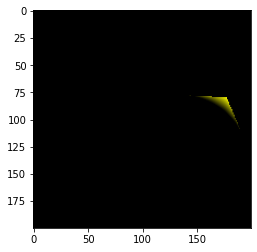

In [86]:
plt.imshow(img)

In [87]:
def rggb(img):
  r_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  r_m[0::2, 0::2] = 1
  g1_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  g1_m[0::2, 1::2] = 1
  g2_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  g2_m[1::2, 0::2] = 1
  b_m = np.zeros(shape=img.shape[:2], dtype=np.uint8)
  b_m[1::2, 1::2] = 1

  return (img[:,:,0] * r_m) + (img[:,:,1] * g1_m) + (img[:,:,1] * g2_m) + (img[:,:,2] * b_m)

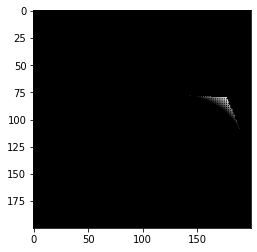

In [88]:
img_rggb = rggb(img)
plt.imshow(img_rggb, cmap='gray')

In [89]:
plt.imsave('test_rggb.png', img_rggb, dpi=300, cmap='gray')

In [90]:
img_rggb.dtype

dtype('uint8')

In [91]:
import bilinear
output_img = bilinear.debayer_bilinear(img_rggb)

In [92]:
output_img.dtype

dtype('float32')

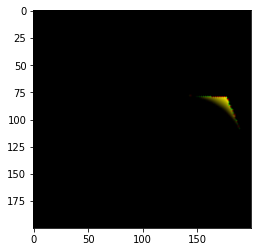

In [93]:
plt.imshow(output_img)

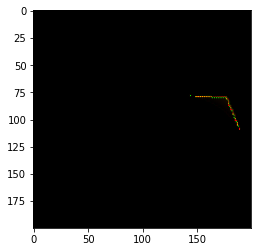

In [94]:
plt.imshow((output_img * 255).astype(np.uint8)-img)